In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/My\ Drive/arabic-ocr/handwritten_arabic_letters

In [3]:
import os
from PIL import Image, ImageChops
import numpy as np
from numpy import savetxt
from numpy import loadtxt
from matplotlib import pyplot as plt
import pandas as pd
import cv2

In [4]:
def trim(image):
    image=Image.fromarray(image)
    bg = Image.new(image.mode, image.size, image.getpixel((0,0))) # black background
    diff = ImageChops.difference(image, bg)
    diff = ImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    if bbox:
        return np.array(image.crop(bbox))
# cv2.INTER_AREA: examiner les pixels voisins et utiliser ces voisins pour augmenter ou diminuer optiquement la taille de l’image sans introduire de distorsions
def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    dim = None
    (h, w) = image.shape[:2]
    if width is None and height is None:
        return image
    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)
    else:
        #r = width / float(w)
        #dim = (width, int(h * r))
        dim = (width,height)
    resized = cv2.resize(image, dim, interpolation = inter)
    return resized
def cleaned_image(image):
    bg=np.ones((28,28))
    bg = bg*255
    image=trim(image)
    if image is not None:
        image = image_resize(image,height=28)
    else:
        return None
    #image=image_resize(image,height=28)
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh, image_binary = cv2.threshold(image_gray, 128, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    hh, ww = bg.shape
    h, w = image_binary.shape
    yoff = round((hh-h)/2)
    xoff = round((ww-w)/2)
    if xoff<=0:
        image=image_resize(image,height=28,width=28)
        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        thresh, image_binary = cv2.threshold(image_gray, 128, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        h, w = image_binary.shape
        yoff = round((hh-h)/2)
        xoff = round((ww-w)/2)
    result = bg.copy()
    result[yoff:yoff+h, xoff:xoff+w] = image_binary
    return result

In [ ]:
# List of folders containing images
folders = os.listdir('/content/isolated_alphabets_per_alphabet')
#folders = ['ain_begin']
columns=["pixel_{:01d}".format(x) for x in range(784)]
# Create an empty DataFrame to store the features and labels
data = pd.DataFrame(columns=[*columns, 'label'])

# Iterate through each folder
for number,folder in enumerate(folders):
    path = '/content/isolated_alphabets_per_alphabet/'+folder
    # List all the images in the folder
    images = os.listdir(path)[:200]
    print("---------------- folder number: {} -----------------".format(number))
    # Iterate through each image
    for index,image in enumerate(images):
        # Read the image
        #Im = cv2.imread(os.path.join(path, image))
        Im = cv2.imread(path+'/'+image)
        #Im = Image.open(path+'/'+image)
        # Convert the image to grayscale
        #Im = Im.convert("L")
        # Adjust the contrast
        #Im = Im.point(lambda x: 0 if x<128 else 255, "1")
        # Resize the image to a fixed size
        #Im = Im.resize((280, 128))
        if cleaned_image(Im) is None:
          print('# image {}/{} is a NoneType object, so skip this.'.format(path,image))
          continue
        Im = cleaned_image(Im)
        #pixels.append(list(Im.getdata()))
        row = Im.flatten().tolist()
        #row = list(Im.getdata())
        # Add the features and label to the DataFrame
        data.loc[len(data)] = [*row, folder]
        #data = data.append(pd.DataFrame([*row, folder], columns=[*columns, 'label']), ignore_index=True)
        print("progress: {}".format(index))

In [6]:
data.head()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_775,pixel_776,pixel_777,pixel_778,pixel_779,pixel_780,pixel_781,pixel_782,pixel_783,label
0,255.0,255.0,255.0,255.0,0.0,0.0,0.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,sad_regular
1,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,sad_regular
2,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,sad_regular
3,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,sad_regular
4,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,sad_regular


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12997 entries, 0 to 12996
Columns: 785 entries, pixel_0 to label
dtypes: float64(784), object(1)
memory usage: 77.9+ MB


In [8]:
# Store the DataFrame as a CSV file
data.to_csv("handwritten_arabic_letters_2.csv", index=False)

In [ ]:
from google.colab import files

files.download("handwritten_arabic_letters_1.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [9]:
!cp handwritten_arabic_letters_2.csv "gdrive/My Drive/arabic-ocr/"

In [10]:
data = pd.read_csv('/content/gdrive/MyDrive/arabic-ocr/handwritten_arabic_letters_2.csv')

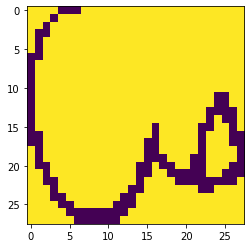

In [11]:
X = data.drop(columns=['label'])
first_row = np.asarray(list(X.iloc[0])).reshape(28,28)
plt.imshow(first_row)

In [14]:
labels = data.label.unique()
labels

array(['sad', 'alif', 'ain', 'kaf', 'qaf', 'noon', 'jeem', 'lam', 'tah',
       'feh', 'seen', 'heh', 'meem', 'dal', 'beh', 'waw', 'raa', 'yaa'],
      dtype=object)

In [13]:
data.label = data.label.apply(lambda x: x.split('_')[0])
label_map = {'ain':0,
          'alif':1,
          'beh':2,
          'dal':3,
          'feh':4,
          'heh':5,
          'jeem':6,
          'kaf':7,
          'lam':8,
          'meem':9,
          'noon':10,
          'qaf':11,
          'raa':12,
          'sad':13,
          'seen':14,
          'tah':15,
          'waw':16,
          'yaa':17
          }


In [15]:
# Use the map function to transform the labels
data.label = data.label.map(label_map)
data.label

0        13
1        13
2        13
3        13
4        13
         ..
12992     8
12993     8
12994     8
12995     8
12996     8
Name: label, Length: 12997, dtype: int64

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12997 entries, 0 to 12996
Columns: 785 entries, pixel_0 to label
dtypes: float64(784), int64(1)
memory usage: 77.8 MB


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [40]:
# Split the DataFrame into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['label']), data['label'], test_size=0.2,random_state=101)

# Train a random forest classifier
clf = RandomForestClassifier(n_estimators=200, max_features='sqrt', bootstrap=True)
clf.fit(X_train, y_train)

# Test the classifier on the test set
accuracy = clf.score(X_test, y_test)
print(f'Test accuracy: {accuracy:.2f}')

Test accuracy: 0.70


In [21]:
# Test the classifier on the test set
accuracy = clf.score(X_train, y_train)
print(f'Train accuracy: {accuracy:.2f}')

Train accuracy: 1.00


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


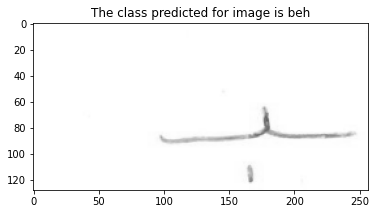

In [34]:
image_test = cv2.imread('/content/isolated_alphabets_per_alphabet/beh_middle/user082_beh_middle_010.png')
Im = cleaned_image(image_test)
vect = Im.flatten().tolist()
value = clf.predict([vect])[0]
key = [k for k, v in label_map.items() if v == value]
plt.title('The class predicted for image is ' + key[0])
plt.imshow(image_test)
plt.show()

In [35]:
parameters = {'n_estimators': [10, 50, 100, 200],
              'max_depth': [None, 10, 20, 30],
              'max_features': ['auto', 'sqrt', 'log2']}

In [36]:
# Create a random forest classifier
clf = RandomForestClassifier()

# Use grid search to find the best hyperparameters
grid_search = GridSearchCV(clf, parameters, cv=5)
# Fit the grid search object to the training data
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 10, 20, 30],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [10, 50, 100, 200]})

In [37]:
# Get the best hyperparameters
best_params = grid_search.best_params_

# Get the best score
best_score = grid_search.best_score_


In [38]:
best_params

{'max_depth': None, 'max_features': 'auto', 'n_estimators': 200}

In [39]:
best_score

0.682025752025752